In [124]:
from keras.models import Sequential
from keras.layers import GRU ,Dense , Embedding
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


np.random.seed(123)

In [18]:
#dataseti dahil etme
dataset = pd.read_csv("yorumsepeti.csv" , sep=";" ,encoding='utf-8' )

In [19]:
dataset.shape

(60242, 4)

In [21]:
dataset.sample(5)

,speed,service,flavour,review
33567,9,9,9,İzmir kokoreç tavsiye ederim.
11896,10,10,10,Çok iyi pişmişti gayet hızlı geldi ve lezzetli...
42330,10,10,10,Çok hızlı.
1958,10,6,10,Fiyatlar sürekli değişiyor sözde indirim var a...
25641,1,1,1,Yemeğimi başka adrese teslim etmişler.


In [22]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60242 entries, 0 to 60241
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   speed    60242 non-null  object
 1   service  60242 non-null  object
 2   flavour  60242 non-null  object
 3   review   60209 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


In [27]:
dataset.isnull().sum()

speed       0
service     0
flavour     0
review     33
dtype: int64

In [28]:
dataset = dataset.dropna(axis = 0)

In [29]:
dataset.isnull().sum()

speed      0
service    0
flavour    0
review     0
dtype: int64

In [36]:
dataset.shape

(60209, 4)

In [34]:
dataset.head()

,speed,service,flavour,review
0,-,1,1,Her zaman komşu fırından sipariş verdiğim için...
1,-,10,2,sosisli ürün isteyen adama peynirli bişey yol...
2,-,10,10,Siparisimi cok hizli getiren ekip arkadasiniza...
3,1,1,7,"After waiting more tjan one hour, they didnt d..."
4,4,4,1,Iyi pişsin diye söylememe rağmen az pişmiş gel...


In [33]:
dataset.columns

Index(['speed', 'service', 'flavour', 'review'], dtype='object')

In [66]:
#olumlu ve olumsuz degerleri atama
scor = []
for i in range(0,dataset.shape[0]):
    speed = [ 1  if dataset['speed'].iloc[i].strip() == '-' else int(dataset['speed'].iloc[i])]
    service = [ 1  if dataset['service'].iloc[i].strip() == '-' else int(dataset['service'].iloc[i])]
    flavour = [ 1  if dataset['flavour'].iloc[i].strip() == '-' else int(dataset['flavour'].iloc[i])]
    temp  = speed[0] * service[0] * flavour[0]
    if temp > 500 :
        scor.append(1)
    else :
        scor.append(0)
    


In [68]:
dataset["scor"] = scor

In [73]:
dataset.head(10)

,speed,service,flavour,review,scor
0,-,1,1,Her zaman komşu fırından sipariş verdiğim için...,0
1,-,10,2,sosisli ürün isteyen adama peynirli bişey yol...,0
2,-,10,10,Siparisimi cok hizli getiren ekip arkadasiniza...,0
3,1,1,7,"After waiting more tjan one hour, they didnt d...",0
4,4,4,1,Iyi pişsin diye söylememe rağmen az pişmiş gel...,0
5,1,1,1,kokmuş hamburger getirdiniz be ayıp ulan resm...,0
6,10,10,10,Her yiyeceği özenle getiriyolar ve lezzeti old...,1
7,1,1,1,Allah affetsin çok kötüydü hiç bir şey mi iyi ...,0
8,10,10,9,Tavsiye ederim.,1
9,7,7,2,Dürüm bozukdu ve çok kötü kokuyordu.,0


In [77]:
#Buyuk harfleri küçük harf yapma
lower_dataset = dataset.copy()
lower_dataset=lower_dataset["review"].apply(lambda x : " ".join(word.lower() for word in x.split()))
lower_dataset.head(10)

0    her zaman komşu fırından sipariş verdiğim için...
1    sosisli ürün isteyen adama peynirli bişey yoll...
2    siparisimi cok hizli getiren ekip arkadasiniza...
3    after waiting more tjan one hour, they didnt d...
4    iyi pişsin diye söylememe rağmen az pişmiş gel...
5    kokmuş hamburger getirdiniz be ayıp ulan resme...
6    her yiyeceği özenle getiriyolar ve lezzeti old...
7    allah affetsin çok kötüydü hiç bir şey mi iyi ...
8                                      tavsiye ederim.
9                 dürüm bozukdu ve çok kötü kokuyordu.
Name: review, dtype: object

In [84]:
#noktalama işaretlerini silme
nokta_dataset = lower_dataset.copy()
nokta_dataset = nokta_dataset.str.replace("[^\w\s]","")
nokta_dataset = pd.DataFrame(nokta_dataset)
nokta_dataset.head(10)

,review
0,her zaman komşu fırından sipariş verdiğim için...
1,sosisli ürün isteyen adama peynirli bişey yoll...
2,siparisimi cok hizli getiren ekip arkadasiniza...
3,after waiting more tjan one hour they didnt de...
4,iyi pişsin diye söylememe rağmen az pişmiş gel...
5,kokmuş hamburger getirdiniz be ayıp ulan resme...
6,her yiyeceği özenle getiriyolar ve lezzeti old...
7,allah affetsin çok kötüydü hiç bir şey mi iyi ...
8,tavsiye ederim
9,dürüm bozukdu ve çok kötü kokuyordu


In [92]:
#stopWordsların silinmesi
stopWord_dataset = nokta_dataset.copy() 
sw = stopwords.words("turkish")
stopWord_dataset = stopWord_dataset.review.apply(lambda x : " ".join(word  for word in x.split()
                                                                    if word not in sw))
data = pd.DataFrame(stopWord_dataset)
target = dataset["scor"]
data["target"] =  target 
data.sample(10)

,review,target
17334,fiyatına göre iyi olmalıydı içinde meyve oranı,1
18287,tesekurler,1
56781,inanilmaz hizlisiniz,1
14661,genel olarak siparis verdigim memnun kaldigim ...,1
13722,köftenin tadını beğenmedim,1
9171,zamanki mükemmel yemeksepetinin açık ara farkl...,1
1197,adana dürüm siparişi verdim içine tavuk eti ka...,0
32953,pizza hamuru biraz ince olabilirdi,0
42572,lezzetli lavaşlar mükemmeldi doyurucu bulgur p...,1
13306,cok iyi ikramlari oyle,1


In [120]:
x = data["review"].values.tolist()
y = data["target"].values.tolist()
#datayı egitim için boluyoruz
x_train, x_test , y_train, y_test =  train_test_split(x, y,
                                                     test_size = 0.1, random_state = 42)
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))
y_train = np.array(y_train)
y_test = np.array(y_test)

54188
6021
54188
6021


In [102]:
#Tokenleştirme
num_words = 10000 # bag of words
tokenizer = Tokenizer(num_words= num_words)
tokenizer.fit_on_texts(x)
tokenizer.word_index



{'geldi': 1,
 'bir': 2,
 'sağlık': 3,
 'güzel': 4,
 'iyi': 5,
 'güzeldi': 6,
 'lezzetli': 7,
 'teşekkürler': 8,
 'hızlı': 9,
 'sipariş': 10,
 'ederim': 11,
 'lezzet': 12,
 'cok': 13,
 'lezzetliydi': 14,
 'teşekkür': 15,
 'elinize': 16,
 'gayet': 17,
 'ellerinize': 18,
 'servis': 19,
 'biraz': 20,
 'sıcak': 21,
 'kurye': 22,
 'kadar': 23,
 'tavsiye': 24,
 '1': 25,
 'iyiydi': 26,
 'gerçekten': 27,
 'harika': 28,
 'olarak': 29,
 'tavuk': 30,
 'tadı': 31,
 '10': 32,
 'yok': 33,
 'lezzeti': 34,
 'ilk': 35,
 'kötü': 36,
 'mükemmel': 37,
 'ayrıca': 38,
 'fakat': 39,
 'hız': 40,
 'değil': 41,
 'yemek': 42,
 'tek': 43,
 'soğuk': 44,
 'bi': 45,
 'herşey': 46,
 'bol': 47,
 'sadece': 48,
 'yoktu': 49,
 'rağmen': 50,
 'yediğim': 51,
 '2': 52,
 'geç': 53,
 'böyle': 54,
 'köfte': 55,
 'fazla': 56,
 'değildi': 57,
 'lahmacun': 58,
 'sonra': 59,
 'başarılı': 60,
 'olsun': 61,
 'ederiz': 62,
 'ekmek': 63,
 'verdim': 64,
 'içinde': 65,
 'gelen': 66,
 'memnun': 67,
 'tam': 68,
 'var': 69,
 'kesinlikle': 7

In [108]:
x_train_token = tokenizer.texts_to_sequences(x_train)
x_test_token = tokenizer.texts_to_sequences(x_test)
x_train[18966]

'lezzetini pek beğendim'

In [109]:
x_train_token[18966]

[680, 234, 103]

In [111]:
#padding input için boyutları hepsini aynı yapma
num_tokens = [len(token) for token in x_train_token + x_test_token] #liste halinde token uzunlukları tutma
num_tokens = np.array(num_tokens)

#input uzunlugu mean + 2 * std = %95
max_token = int(np.mean(num_tokens) + 2 * np.std(num_tokens))
print(max_token)


23


In [113]:
x_train_pad = pad_sequences(x_train_token, maxlen= max_token)
x_test_pad = pad_sequences(x_test_token, maxlen = max_token)
x_train_pad[18966]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0, 680, 234, 103])

In [116]:
#model
embedding_size = 50 #kaç kelime arası ilişki olsun
model = Sequential()
model.add(Embedding(input_dim = num_words , output_dim = embedding_size,
                   input_length = max_token , name = "embedding"))
model.add(GRU(16 , return_sequences = True))
model.add(GRU(8, return_sequences = True))
model.add(GRU(4, return_sequences = False))
model.add(Dense(1, activation = "sigmoid"))

model.compile(loss = "binary_crossentropy", optimizer = Adam(learning_rate= 1e-3),
             metrics = ["accuracy"])

In [117]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 23, 50)            500000    
_________________________________________________________________
gru_5 (GRU)                  (None, 23, 16)            3264      
_________________________________________________________________
gru_6 (GRU)                  (None, 23, 8)             624       
_________________________________________________________________
gru_7 (GRU)                  (None, 4)                 168       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 504,061
Trainable params: 504,061
Non-trainable params: 0
_________________________________________________________________


list

In [121]:
hist = model.fit(x_train_pad, y_train, epochs = 5 , batch_size = 64)


Epoch 1/5
847/847 [==============================] - 43s 25ms/step - loss: 0.4437 - accuracy: 0.8041
Epoch 2/5
847/847 [==============================] - 21s 25ms/step - loss: 0.3028 - accuracy: 0.89080s - loss: 0.3028 - accura
Epoch 3/5
847/847 [==============================] - 21s 25ms/step - loss: 0.2669 - accuracy: 0.9096
Epoch 4/5
847/847 [==============================] - 21s 25ms/step - loss: 0.2426 - accuracy: 0.9203
Epoch 5/5
847/847 [==============================] - 21s 25ms/step - loss: 0.2165 - accuracy: 0.9319


In [122]:
model.save("model.h5")
model.save_weights("model_weights.h5")

In [123]:
#degerlendirme
result = model.evaluate(x_test_pad, y_test)
print("Loss : {} , Acc : {}".format(result[0], result[1]))

189/189 [==============================] - 2s 3ms/step - loss: 0.4208 - accuracy: 0.8482
Loss : 0.42078888416290283 , Acc : 0.8481979966163635


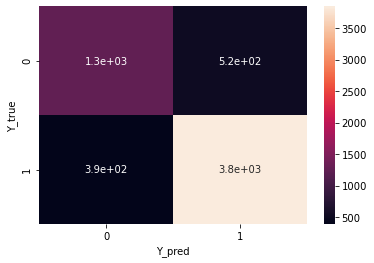

In [129]:
#cm
y_pred = model.predict(x_test_pad)
y_pred[y_pred > 0.5] = 1
y_pred[y_pred < 0.5] = 0

cm = confusion_matrix(y_test ,y_pred)

sns.heatmap(cm, annot = True)
plt.xlabel("Y_pred")
plt.ylabel("Y_true")
plt.show()

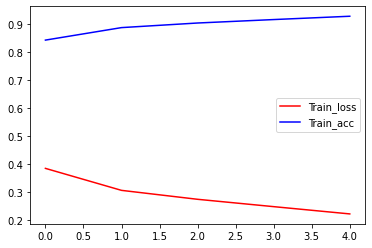

In [137]:
plt.figure()
plt.plot(hist.history["loss"], color = "red", label = "Train_loss")
plt.plot(hist.history["accuracy"], color = "blue",label = "Train_acc")
plt.legend()
plt.show()


In [141]:
#real test
def proces_text_pred(texts):
    #kucuk harf
    text = texts.lower()
    #noktalama
    text = re.sub('[^a-zA-Z]',' ',text) 
    text = " ".join(word  for word in text.split() if word not in sw)
    return text




In [144]:
text1 = proces_text_pred("Seni seviyorum")
text2 = proces_text_pred("Siparişde soyledigim halde halen gelmedi.")
text3 = proces_text_pred("Yaşıyoruz bu hayatı Çok Şükür")

text = [text1 ,text2, text3]
text_token = tokenizer.texts_to_sequences(text)
text_token_pad = pad_sequences(text_token ,maxlen = max_token)

text_pred = model.predict(text_token_pad)
print(text_pred)

[[0.967803  ]
 [0.07333779]
 [0.9680811 ]]
